# Tiling experiments
This paperwork will analyze data obtained from tiling experiments to compare 4 features of 4 different algorithms' implementations.

The features or variables to measure are the following:
- Algorithm speed up
- Cache misses
- Total of instructions executed
- Cores rate usage

The 4 algorithms selected for the experiment were:
- Matrix multiplication
- Vector multiplication
- Jacobi Example
- ? (still in process)

For each algorithm will have 4 versions
- Original implementation.
- Tiled and handed parallelized algorithm from a benchmark.
- Tiled and parallelized algorithm using Cetus.
- Tiled, parallelized and loop interchange applied algorithm using Cetus.

## Methodology

The proposed methodology is, we will have 4 different versions for each algorithm and will measure the features above for each of them. After that, we are going to use the data obtained to see if tiling improves the algorithms' performance.

For each measurement the independent variable will be the amount ofcores to use for each experiment instance.

## Data creation
For obtaining/creating the data, we will use a group of tools to obtain data in runtime. Those tools are the following:
- PAPI: To access hardware counters and to measure: Cache misses and total of instructions executed
- OMP directives: To measure elapsed time for an algorithm execution and to measure speed up and cores rate usage.

## Experiment results

In [12]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

default_tick_format_style = 'sci'
all_versions = ['parallel-non-tiled','parallel-paw-tiled', 'parallel-paw-single-tiled']

In [14]:
df = pd.read_csv("./experiments/results.csv", names=['algorithm','version', 'cores', 'experiment', 'N','M','tileSize','value'])
df

,algorithm,version,cores,experiment,N,M,tileSize,value
0,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,151.155040
1,matrix-mult,parallel-paw-tiled,1,speed-up,2805,2805,16,95.841051
2,matrix-mult,parallel-paw-single-tiled,1,speed-up,2805,2805,16,112.980328
3,vector-mult,parallel-non-tiled,1,speed-up,4000,5896,0,0.075086
4,vector-mult,parallel-paw-tiled,1,speed-up,4000,5896,16,0.085560
...,...,...,...,...,...,...,...,...
2415,jacobi,parallel-paw-tiled-loop-inter,4,speed-up,4858,4858,2000,0.155982
2416,jacobi,parallel-paw-single-tiled-loop-inter,4,speed-up,4858,4858,2000,0.160047
2417,matrix-mult,parallel-non-tiled,7,speed-up,2805,2805,0,43.893160
2418,matrix-mult,parallel-paw-tiled,7,speed-up,2805,2805,2000,130.731817


In [15]:
pp = pd.read_csv("./experiments/test.csv", names=['algorithm','version', 'cores', 'experiment', 'N','M','value'])
pp

,algorithm,version,cores,experiment,N,M,value
0,matrix-mult,parallel-non-tiled,5,cache-misses,1200,1200,5
1,matrix-mult,parallel-non-tiled,5,cache-misses,1200,1200,7
2,matrix-mult,parallel-non-tiled,5,total-i,1200,1200,1
3,matrix-mult,parallel-non-tiled,5,total-i,1200,1200,3
4,matrix-mult,parallel-non-tiled,4,cache-misses,1200,1200,2


In [16]:
def group_by(dataframe, groups=['algorithm', "version", "cores", "experiment"]):
    return dataframe.groupby(groups, as_index=False)

In [17]:
def group_min(dataframe):
    ss = group_by(dataframe, ['algorithm', "version", "cores", "experiment", "tileSize"])
    return ss.min()

group_min(pp)
group_by(pp).std()

,algorithm,version,cores,experiment,N,M,value
0,matrix-mult,parallel-non-tiled,4,cache-misses,NaN,NaN,NaN
1,matrix-mult,parallel-non-tiled,5,cache-misses,0.0,0.0,1.414214
2,matrix-mult,parallel-non-tiled,5,total-i,0.0,0.0,1.414214


In [18]:
def group_mean(dataframe):
    ss = group_by(dataframe, ['algorithm', "version", "cores", "experiment", "tileSize"])
    return ss.mean()

group_mean(pp)


,cores,N,M,value
0,5.0,1200.0,1200.0,5.0
1,5.0,1200.0,1200.0,1.0
2,5.0,1200.0,1200.0,3.0
3,4.0,1200.0,1200.0,2.0
4,5.0,1200.0,1200.0,7.0


In [19]:
def filter_by_experiment(dataframe, algorithm, experiment)->pd.DataFrame:
    filteredAlgorithms = dataframe.loc[(dataframe['algorithm']==algorithm)]
    filteredRows = filteredAlgorithms.loc[dataframe['experiment']==experiment]
    return filteredRows

filter_by_experiment(df,'matrix-mult', 'speed-up').head()
    

,algorithm,version,cores,experiment,N,M,tileSize,value
0,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,151.155040
1,matrix-mult,parallel-paw-tiled,1,speed-up,2805,2805,16,95.841051
2,matrix-mult,parallel-paw-single-tiled,1,speed-up,2805,2805,16,112.980328
9,matrix-mult,parallel-non-tiled-loop-inter,1,speed-up,2805,2805,0,104.009414
10,matrix-mult,parallel-paw-tiled-loop-inter,1,speed-up,2805,2805,16,94.270196


In [20]:
def get_unique(dataframe: pd.DataFrame, name):
    return dataframe[name].unique()

get_unique(df, 'version')

array(['parallel-non-tiled', 'parallel-paw-tiled',
       'parallel-paw-single-tiled', 'parallel-non-tiled-loop-inter',
       'parallel-paw-tiled-loop-inter',
       'parallel-paw-single-tiled-loop-inter'], dtype=object)

In [21]:
def get_experimental_values(dataframe: pd.DataFrame, versions=[], xId='cores', yId='value')->dict:
    if(len(versions) == 0):
        versions=get_unique(dataframe, 'version')
    dictionary={}
    for version in versions:
        dataframe_by_versions = dataframe.loc[dataframe['version']==version]
        x = dataframe_by_versions[xId]
        y = dataframe_by_versions[yId]
        dictionary[version] = {'x': x, 'y':y}
    return dictionary
matrix_mult_speed_df = filter_by_experiment(df,'matrix-mult','speed-up')
experiment = get_experimental_values(matrix_mult_speed_df)
experiment.keys()

dict_keys(['parallel-non-tiled', 'parallel-paw-tiled', 'parallel-paw-single-tiled', 'parallel-non-tiled-loop-inter', 'parallel-paw-tiled-loop-inter', 'parallel-paw-single-tiled-loop-inter'])

In [22]:
matrix_mult_speed_df = filter_by_experiment(df,'matrix-mult','speed-up')
experiment = get_experimental_values(matrix_mult_speed_df, ['parallel-paw-single-tiled','parallel-non-tiled'])
experiment.keys()

dict_keys(['parallel-paw-single-tiled', 'parallel-non-tiled'])

In [23]:
def get_plottable_experiment(experiment: dict)->dict:
    colors = ['b','g','r','c','m','y','k']
    colors.reverse()
    dictionary = {}
    for version in experiment:
        x=experiment[version]['x']
        y=experiment[version]['y']
        dictionary[version]={'x':x, 'y':y ,'color':colors.pop()}
    return dictionary

matrix_mult_speed_df = filter_by_experiment(df,'matrix-mult','speed-up')
experiment = get_experimental_values(matrix_mult_speed_df)
plottable_experiment = get_plottable_experiment(experiment)
plottable_experiment['parallel-non-tiled']['x'].head()

0     1
18    1
36    1
39    4
57    4
Name: cores, dtype: int64

In [24]:
def plot_scatter(experiment, versions=all_versions,tick_format_style=default_tick_format_style ):
    
    fig=plt.figure(figsize=(25, 8))
        
    gg=0
    min_y = 0
    max_y = 0
    
    
    for version in versions:
        canva = fig.add_subplot(131+gg)
        gg+=1
        canva.title.set_text(version)
        x = exp[version]['x']
        y = exp[version]['y']
        
        max_y = max(max_y, y.max())
        min_y = min(min_y, y.min())
        
        #plt.ylim([min_y, max_y])

        c = exp[version]
        plt.plot(x, y, 'o')
        plt.ticklabel_format(style=tick_format_style, axis='y', scilimits=(0,0))
        
        if len(x) == 1 or len(x.drop_duplicates())==1:
            continue
        
        m, b = np.polyfit(x, y, 1)
        plt.plot(x, m*x+b)
    

    plt.show()

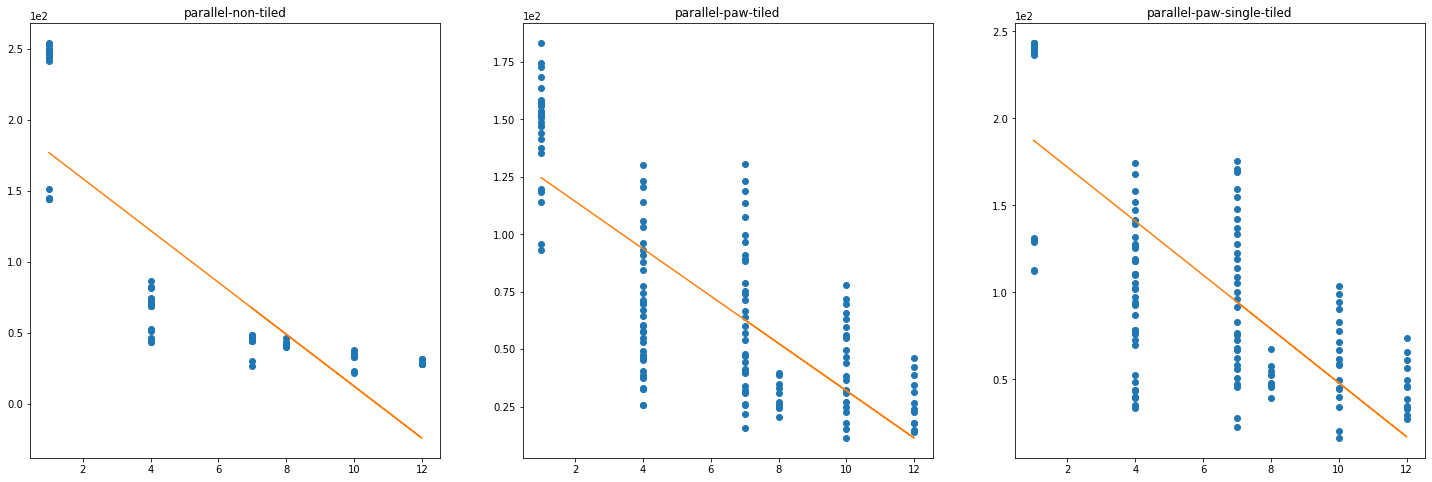

In [25]:
fdf = filter_by_experiment(df,'matrix-mult', 'speed-up')
exp = get_experimental_values(fdf)
plot_exp = get_plottable_experiment(exp)
plot_scatter(plot_exp)


In [26]:
def plot_lines(dataframe: pd.DataFrame, versions=[], canva=None, title="", tick_format_style=default_tick_format_style):
    
    if(canva==None):
        fig=plt.figure(figsize=(20, 10))
        canva = fig.add_subplot()
        
    
    canva.title.set_text(title)

    plt.ylabel('Values')
    plt.xlabel('# Cores')
    
    
    aux_experiment = get_experimental_values(dataframe,versions)
    experiment = get_plottable_experiment(aux_experiment)
    
       
    x_min=0
    x_max=10
    
    y_min=0
    y_max=10
    
    plt.ticklabel_format(style=tick_format_style, axis='y', scilimits=(0,0))
 
    
    # lines
    for version in experiment.keys():
        color = experiment[version]['color']
        x = experiment[version]['x']
        x_min = x.min()
        x_max = x.max()
        
        y = experiment[version]['y']
        y_min= y.min()
        y_max= y.max()
    
        line, = plt.plot(x, y, color)
        line.set_label(version)
        
    # axh lines
    for version in experiment.keys():
        color = experiment[version]['color']
        y = experiment[version]['y']
        plt.axhline(y=y.min(), color=color, linestyle=":", label='min-'+version)
        plt.legend()
    
#     x_min=x_min-x_min*0.05
#     x_max=x_max+x_max*0.05
    
#     y_min=y_min-y_min*0.1    
#     y_max=y_max+y_max*0.1
    
#     x_lim=[x_min, x_max]
#     y_lim=[y_min, y_max]
    
#     print(str(x_lim))
#     print(str(y_lim))
#     plt.xlim(x_lim)
#     plt.ylim(y_lim)

In [27]:
def plot_bars(dataframe: pd.DataFrame, versions=[], canva=None, tick_format_style=default_tick_format_style):
    
    if(canva==None):
        fig=plt.figure(figsize=(20, 10))
        canva = fig.add_subplot()
    
    # bars
    aux_experiment = get_experimental_values(dataframe,versions)
    experiment = get_plottable_experiment(aux_experiment)
    experiment_keys = list(experiment.keys())
    min_execution_time_version = experiment_keys[0]
    min_execution_time = experiment[min_execution_time_version]['y'].min()
    for version in experiment_keys:
        cur_experiment_time = experiment[version]['y'].min()
        if min_execution_time > cur_experiment_time:
            min_execution_time = cur_experiment_time
            min_execution_time_version = version
        
    version_filtered_df = dataframe.loc[dataframe['version'] == min_execution_time_version]
    cores_df = version_filtered_df.loc[dataframe['value'] == min_execution_time]
    cores_with_min_execution_time = cores_df['cores'].values[0]
    bars_df = dataframe.loc[dataframe['cores']==cores_with_min_execution_time] 
        

    names=[]
    colors=[]
    values=[]
    for version in experiment_keys:
        names.append(version)
        
        val = bars_df.loc[bars_df['version']==version]['value'].values[0]
        values.append(val)
        
        color = experiment[version]['color']
        colors.append(color)


    plt.ticklabel_format(style=tick_format_style, axis='y', scilimits=(0,0))
    
    canva.title.set_text('Bar chart - Cores: '+str(cores_with_min_execution_time))
    
    
    plt.bar(names, values, color=colors)
    
    plt.ylabel('Values')
    plt.xlabel('Versions')



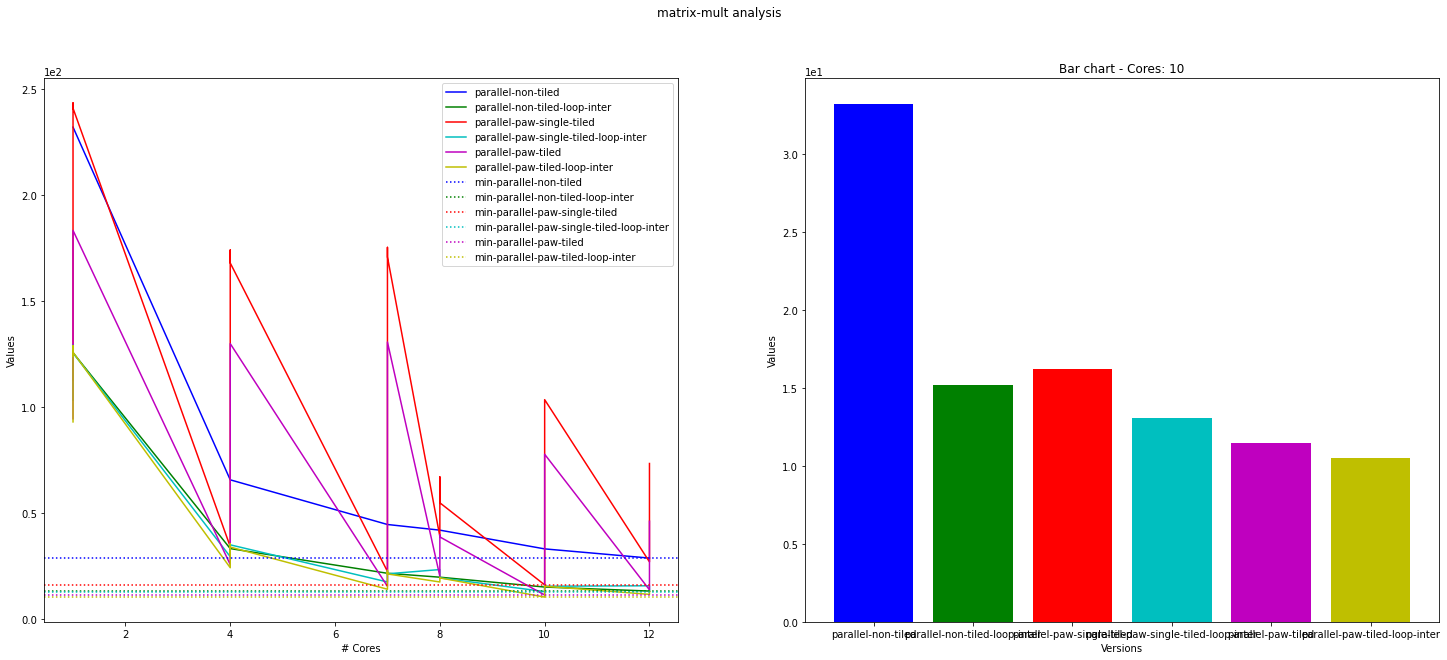

In [28]:
def plot_experiments(experiment_label, dataframe: pd.DataFrame, versions=[], tick_format_style=default_tick_format_style):
    
    fig=plt.figure(figsize=(25, 10))
    
        
    plt.suptitle(experiment_label+' analysis')
    
    canva = fig.add_subplot(121)
    plot_lines(dataframe, versions, canva, tick_format_style=tick_format_style)
    
    canva2 = fig.add_subplot(122)
    plot_bars(dataframe, versions, canva2, tick_format_style=tick_format_style)
    
    plt.show()
    
matrix_mult_speed_df = filter_by_experiment(df,'matrix-mult','speed-up')
plot_experiments('matrix-mult', group_mean(matrix_mult_speed_df))

In [29]:
def plot_bars_group(dataframe: pd.DataFrame, experiments=[]):
    if(len(experiments) == 0):
        experiments=get_unique(dataframe, 'experiment')
    
    return experiments

plot_bars_group(df)

array(['speed-up'], dtype=object)

# Experiment details

- Machine: **DARWIN/CAVINESS**
- **PAPI** for profiling
- **OMP** for paralellization
- **Calloc** for dynamic memory allocation
- **Sbatch** and **slurm** for running experiments

## DARWIN

### Main memory and cache estimations

#### Understanding cache information
- Where to see cache information? ```lscpu | grep cache```

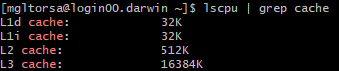

- Is that information exact? To confirm that we could use another command in linux: ```getconf -a | grep CACHE```. This is what we get: 
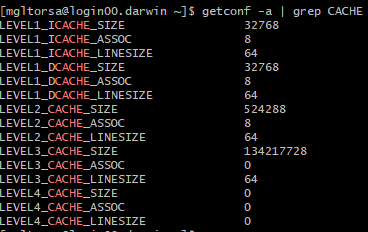 

One can notice L3 size from ```getconf``` does not fit with the last value in the ```lscpu``` command. So, we did the math.

For L3, we found the L3 in the ```getconf``` information is written in bits, while the ```lscpu``` info is written in KiB as we can see in the following example:
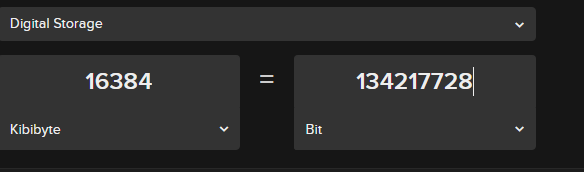

From byte to KiB
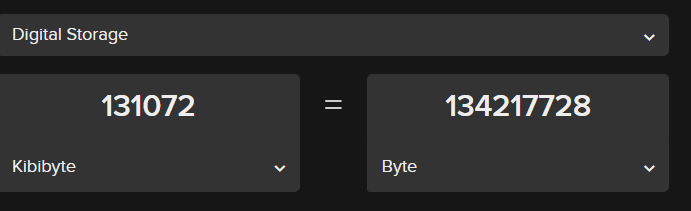

However, for L2, it was not the same. When trying to do the conversion from bits to KiB we got this:
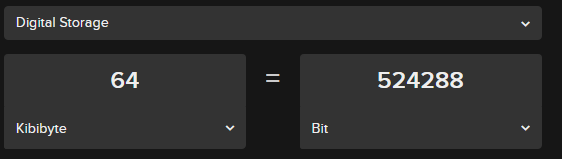

But, after doing the same conversion from bits to Kb we got the expected results:
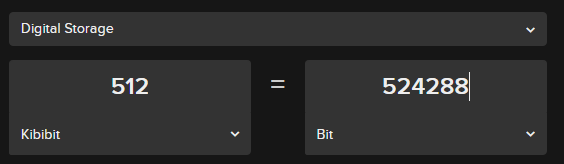

Finally, as expected for L1i and L1d we got the expected results when doing the conversion from bits to Kb:
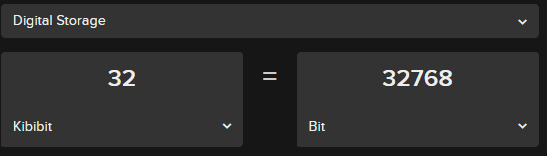


##### Conclusions
After comparing the information, we concluded that all the cache information in ```lscpu``` and ```getconf``` is expressed in Kilobits and bits respectively, except for the information related to L3 cache, which is written in Kibibytes and bits respectively.

#### Filling up the cache

Now, the main question to ask is: what size our matrices/vectors should be for filling up the cache?

To answer this question we should make some math:
   - What is the size (in Bytes) of the Cache? > Darwin: L2 - 512KiB; L3 - 16384KiB (134217728 bits)
   - How many bytes the data type takes in memory/cache? > Float/Integer : 4B (bytes)
   - What is the total number of values that will fit in cache? (cache/type's size): Darwin > 16384KiB/4B

In [30]:
darwin_cache_size_in_bytes=16384 * 1024 #16384KiB
type_size_in_bytes = 4 #4 bytes (integer/float)
darwin_total_values_in_cache = darwin_cache_size_in_bytes/type_size_in_bytes

So, for filling up the cache in a **DARWIN** with a **16384KiB L3 cache**, we should use, at least, the following number of values in cache.

In [31]:
print(f"Total of values to fill up the cache: {round(darwin_total_values_in_cache)}")

darwin_double_cache_values = 2*darwin_total_values_in_cache
print(f"Total of values to double the cache: {round(darwin_double_cache_values)}")

Total of values to fill up the cache: 4194304
Total of values to double the cache: 8388608


### About cache line size and cache associativity

Using the following command we are able to see cache details in linux: 

To get detailed information about cache we could use: ```getconf -a | grep CACHE```
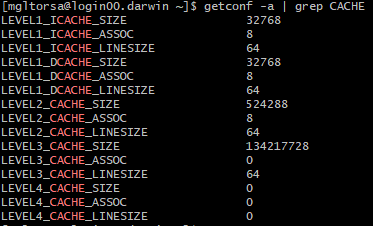


In the last image we can observe details such as SIZE, LINE_SIZE and association for all the cache levels.

In [32]:
darwin_cache_line_size_in_bytes = 64

## CAVINESS

### Main memory and cache estimations

#### Understanding cache information
- Where to see cache information? ```lscpu | grep cache```

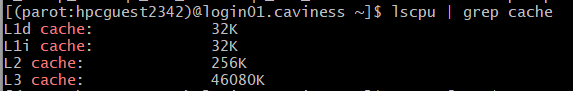

- Is that information exact? To confirm that we could use another command in linux: ```getconf -a | grep CACHE```. This is what we get: 
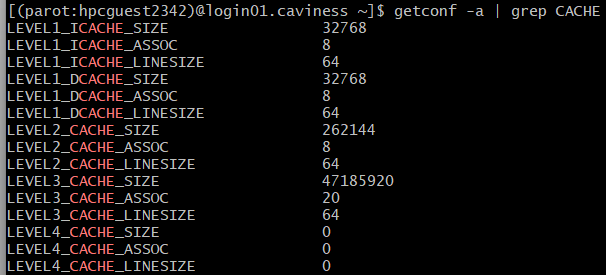 


##### Conclusions
After comparing the information, we concluded that all the cache information in ```lscpu``` and ```getconf``` is expressed in Kilobits and bits respectively.

#### Filling up the cache

Now, the main question to ask is: what size our matrices/vectors should be for filling up the cache?

To answer this question we should make some math:
   - What is the size (in Bytes) of the Cache? > CAVINESS: L3 - 46080KiB; L3 (47185920 bits)
   - How many bytes the data type takes in memory/cache? > Float/Integer : 4 B (bytes)
   - What is the total number of values that will fit in cache? (cache/type's size): CAVINESS' CACHE > 46080 KiB/4 B

In [33]:
caviness_cache_size_in_bytes=46080 * 1024 #16384KiB
type_size_in_bytes = 4 #4 bytes (integer/float)
caviness_total_values_in_cache = caviness_cache_size_in_bytes/type_size_in_bytes

So, for filling up the cache in a **CAVINESS** with a **46080 KiB L3 cache**, we should use, at least, the following number of values in cache.

In [34]:
print(f"Total of values to fill up the cache: {round(caviness_total_values_in_cache)}")

caviness_double_cache_values = 2*caviness_total_values_in_cache
print(f"Total of values to double the cache: {round(caviness_double_cache_values)}")

Total of values to fill up the cache: 11796480
Total of values to double the cache: 23592960


### About cache line size and cache associativity

Using the following command we are able to see cache details in linux: 

To get detailed information about cache we could use: ```getconf -a | grep CACHE```
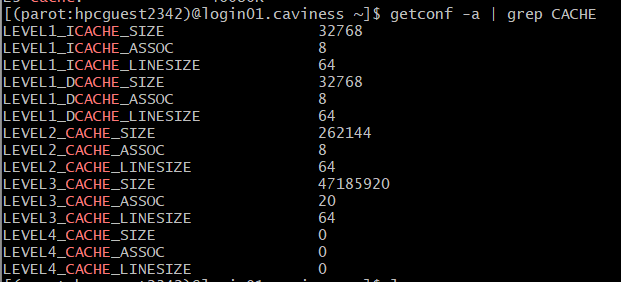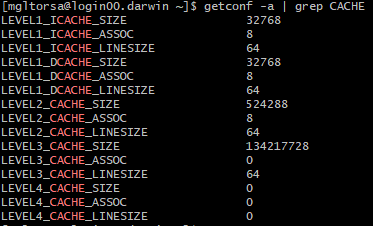


In the last image we can observe details such as SIZE, LINE_SIZE and association for all the cache levels.

In [35]:
caviness_cache_line_size_in_bytes = 64

# Choosing a cluster for experiments

Chosen cluster: **CAVINESS**

In [36]:
double_cache_values = caviness_double_cache_values
cache_size_in_bytes = caviness_cache_size_in_bytes
total_values_in_cache = caviness_total_values_in_cache

print(f"Cache in bytes: {darwin_cache_size_in_bytes}")

Cache in bytes: 16777216


# Choosing tile size

Loading data

In [38]:
tile_size_df = pd.read_csv("./experiments/results-tile-size.csv", names=['algorithm','version', 'cores', 'experiment', 'N','M','tileSize','value'])
tile_size_df

,algorithm,version,cores,experiment,N,M,tileSize,value
0,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,151.155040
1,matrix-mult,parallel-paw-tiled,1,speed-up,2805,2805,16,95.841051
2,matrix-mult,parallel-paw-single-tiled,1,speed-up,2805,2805,16,112.980328
3,vector-mult,parallel-non-tiled,1,speed-up,4000,5896,0,0.075086
4,vector-mult,parallel-paw-tiled,1,speed-up,4000,5896,16,0.085560
...,...,...,...,...,...,...,...,...
3189,jacobi,parallel-paw-tiled-loop-inter,4,speed-up,4858,4858,2000,0.155982
3190,jacobi,parallel-paw-single-tiled-loop-inter,4,speed-up,4858,4858,2000,0.160047
3191,matrix-mult,parallel-non-tiled,7,speed-up,2805,2805,0,43.893160
3192,matrix-mult,parallel-paw-tiled,7,speed-up,2805,2805,2000,130.731817


In [39]:
cores=1
dataframe = tile_size_df[(tile_size_df.cores==cores)]
dataframe

,algorithm,version,cores,experiment,N,M,tileSize,value
0,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,151.155040
1,matrix-mult,parallel-paw-tiled,1,speed-up,2805,2805,16,95.841051
2,matrix-mult,parallel-paw-single-tiled,1,speed-up,2805,2805,16,112.980328
3,vector-mult,parallel-non-tiled,1,speed-up,4000,5896,0,0.075086
4,vector-mult,parallel-paw-tiled,1,speed-up,4000,5896,16,0.085560
...,...,...,...,...,...,...,...,...
3168,vector-mult,parallel-paw-tiled-loop-inter,1,speed-up,4000,5896,2000,0.112746
3169,vector-mult,parallel-paw-single-tiled-loop-inter,1,speed-up,4000,5896,2000,0.101434
3170,jacobi,parallel-non-tiled-loop-inter,1,speed-up,4858,4858,0,0.605167
3171,jacobi,parallel-paw-tiled-loop-inter,1,speed-up,4858,4858,2000,0.441569


In [40]:
versions=['parallel-non-tiled','parallel-paw-tiled','parallel-paw-single-tiled']
df_tl_mm_ex = filter_by_experiment(dataframe, 'matrix-mult','speed-up')
exp = get_experimental_values(df_tl_mm_ex, xId='tileSize', yId='value', versions=versions)
plot_exp = get_plottable_experiment(exp)
df_tl_mm_ex.head()

,algorithm,version,cores,experiment,N,M,tileSize,value
0,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,151.155040
1,matrix-mult,parallel-paw-tiled,1,speed-up,2805,2805,16,95.841051
2,matrix-mult,parallel-paw-single-tiled,1,speed-up,2805,2805,16,112.980328
9,matrix-mult,parallel-non-tiled-loop-inter,1,speed-up,2805,2805,0,104.009414
10,matrix-mult,parallel-paw-tiled-loop-inter,1,speed-up,2805,2805,16,94.270196


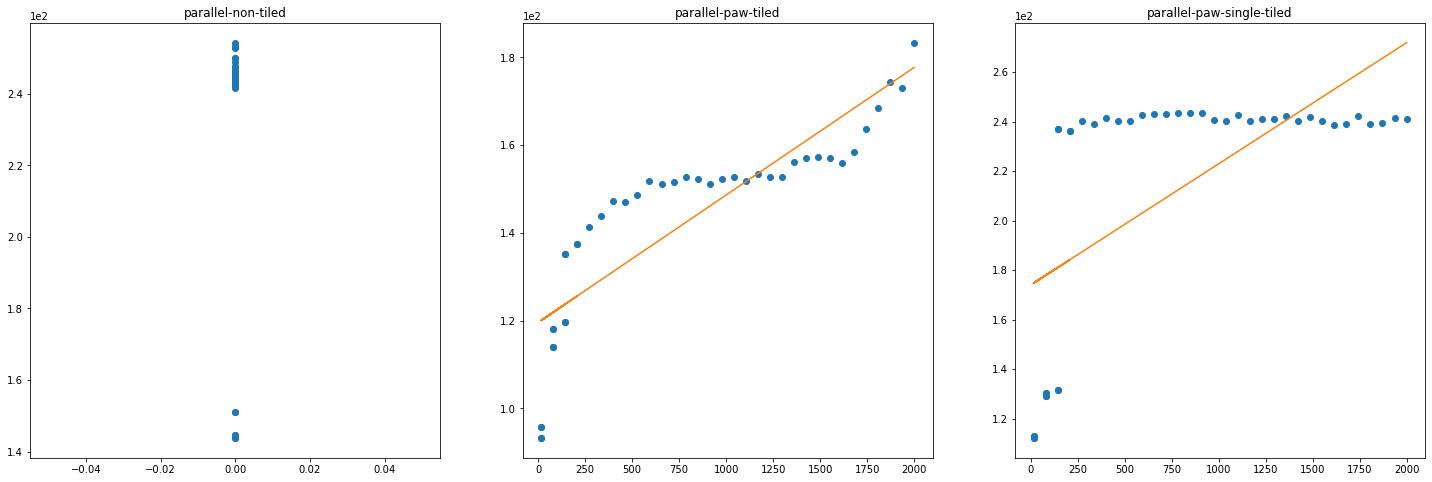

In [41]:
plot_scatter(plot_exp, tick_format_style='sci', versions=versions)

In [42]:
group_mean(df_tl_mm_ex)

,algorithm,version,cores,experiment,tileSize,N,M,value
0,matrix-mult,parallel-non-tiled,1,speed-up,0,2805.0,2805.0,222.666635
1,matrix-mult,parallel-non-tiled-loop-inter,1,speed-up,0,2805.0,2805.0,123.356599
2,matrix-mult,parallel-paw-single-tiled,1,speed-up,16,2805.0,2805.0,112.557333
3,matrix-mult,parallel-paw-single-tiled,1,speed-up,80,2805.0,2805.0,129.813491
4,matrix-mult,parallel-paw-single-tiled,1,speed-up,144,2805.0,2805.0,184.252358
...,...,...,...,...,...,...,...,...
125,matrix-mult,parallel-paw-tiled-loop-inter,1,speed-up,1744,2805.0,2805.0,125.112708
126,matrix-mult,parallel-paw-tiled-loop-inter,1,speed-up,1808,2805.0,2805.0,124.389723
127,matrix-mult,parallel-paw-tiled-loop-inter,1,speed-up,1872,2805.0,2805.0,126.369371
128,matrix-mult,parallel-paw-tiled-loop-inter,1,speed-up,1936,2805.0,2805.0,125.356206


In [43]:
aux_experiment = get_experimental_values(group_mean(df_tl_mm_ex),xId='tileSize', yId='value', versions=versions)
del aux_experiment['parallel-non-tiled']

## 1 core

In [46]:
aux_experiment_non_tiled = get_experimental_values(df_tl_mm_ex,xId='tileSize', yId='value', versions=['parallel-non-tiled'])
non_tiled_x_array = aux_experiment_non_tiled['parallel-non-tiled']['x']
non_tiled_y_array = aux_experiment_non_tiled['parallel-non-tiled']['y']

nt_x_min = non_tiled_x_array.min()
nt_x_max = non_tiled_x_array.max()

nt_y_min = non_tiled_y_array.min()
nt_y_max = non_tiled_y_array.max()

nt_y_mean = non_tiled_y_array.mean()

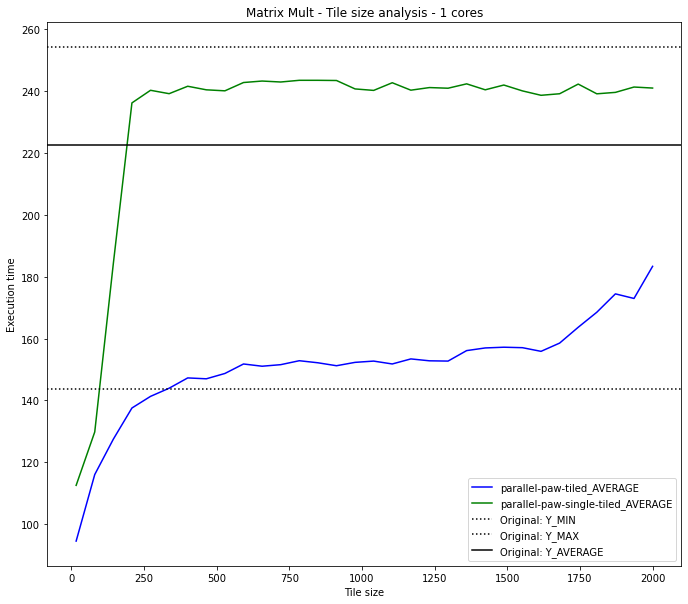

In [49]:
fig=plt.figure(figsize=(25, 10))
    
            
canva = fig.add_subplot(121)

title="Matrix Mult - Tile size analysis - "+ str(cores) + " cores"
canva.title.set_text(title)

plt.ylabel('Execution time')
plt.xlabel('Tile size')
    

experiment = get_plottable_experiment(aux_experiment)
    
       
x_min=0
x_max=10
    
y_min=0
y_max=10
    
plt.ticklabel_format(axis='y', scilimits=(0,0))
 
    
# lines
for version in experiment.keys():
    color = experiment[version]['color']
    x = experiment[version]['x']
    x_min = x.min()
    x_max = x.max()
        
    y = experiment[version]['y']
    y_min= y.min()
    y_max= y.max()
    
    line, = plt.plot(x, y, color)
    line.set_label(version+"_AVERAGE")
        

#plt.xlim(x_min,x_max)
plt.xscale('linear')
plt.yscale('linear')



plt.axhline(y=nt_y_min, color='black', linestyle=":", label='Original: Y_MIN')
plt.axhline(y=nt_y_max, color='black', linestyle=":", label='Original: Y_MAX')
plt.axhline(y=nt_y_mean, color='black', linestyle="-", label='Original: Y_AVERAGE')



plt.legend()


# Matrix multiplication

## Matrix size
For matrix multiplication we require 3 matrices. Looking for filling up the cache twice we will need to split double of the total amount of values in cache through the 3 matrices.
- Matrices will be **square**
- Data type: **float**

In [59]:
num_matrices = 3
total_values_per_matrix=double_cache_values/num_matrices
N_matrix = math.ceil(math.sqrt(total_values_per_matrix))
print(f"float type size: {round(type_size_in_bytes)}")
print(f"Total floating numbers to fill up cache: {round(total_values_in_cache)}")
print(f"Total floating numbers to double cache: {round(double_cache_values)}")
print(f"min floating numbers required per matrix (3 matrices): {round(total_values_per_matrix)}")

print(f"rows and cols per matrix: {round(N_matrix)}")
print(f"total floating numbers per matrix (3 matrices): {round(N_matrix*N_matrix)}")

m=N_matrix
n=N_matrix

print(f"is cache smaller: {cache_size_in_bytes < (((8*m)*n)+((4*n)*n))}")
print(f"is worth to parallelize: {m*n*n>100000}")

cores=1
print(math.sqrt(cache_size_in_bytes* 0.7 / 4)/cores)


float type size: 4
Total floating numbers to fill up cache: 11796480
Total floating numbers to double cache: 23592960
min floating numbers required per matrix (3 matrices): 7864320
rows and cols per matrix: 2805
total floating numbers per matrix (3 matrices): 7868025
is cache smaller: True
is worth to parallelize: True
2873.5928730423866


### Execution time

First we are going to take a look at the scattered behaviour of the execution times took from matrix multiplication's experiments.

In [62]:
df_mm_ex = filter_by_experiment(df,'matrix-mult','speed-up')
df_mm_ex[df_mm_ex.cores==8]

,algorithm,version,cores,experiment,N,M,tileSize,value
184,matrix-mult,parallel-non-tiled,8,speed-up,2805,2805,0,43.491862
185,matrix-mult,parallel-paw-tiled,8,speed-up,2805,2805,16,20.296698
186,matrix-mult,parallel-paw-single-tiled,8,speed-up,2805,2805,16,39.068730
193,matrix-mult,parallel-non-tiled-loop-inter,8,speed-up,2805,2805,0,19.847260
194,matrix-mult,parallel-paw-tiled-loop-inter,8,speed-up,2805,2805,16,17.594571
195,matrix-mult,parallel-paw-single-tiled-loop-inter,8,speed-up,2805,2805,16,23.463794
202,matrix-mult,parallel-non-tiled,8,speed-up,2805,2805,0,41.652543
203,matrix-mult,parallel-paw-tiled,8,speed-up,2805,2805,80,24.601984
204,matrix-mult,parallel-paw-single-tiled,8,speed-up,2805,2805,80,45.610761
211,matrix-mult,parallel-non-tiled-loop-inter,8,speed-up,2805,2805,0,19.869638


In [198]:
print(214*214 * 8)
print(214/)

366368


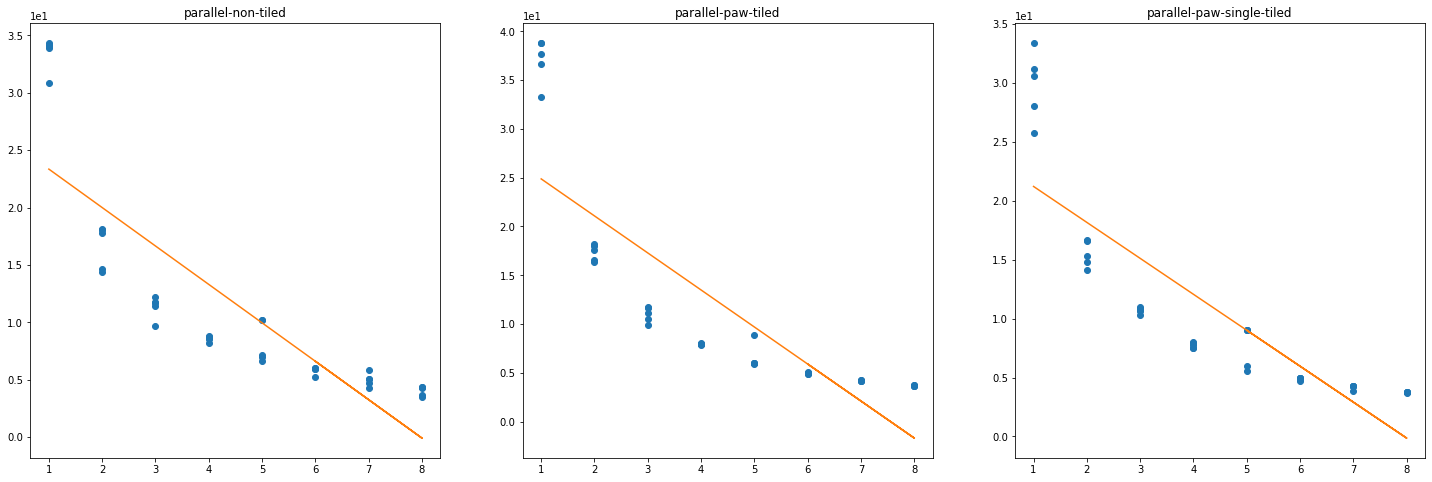

In [168]:
exp = get_experimental_values(df_mm_ex)
plot_exp = get_plottable_experiment(exp)
plot_scatter(plot_exp, tick_format_style='sci')

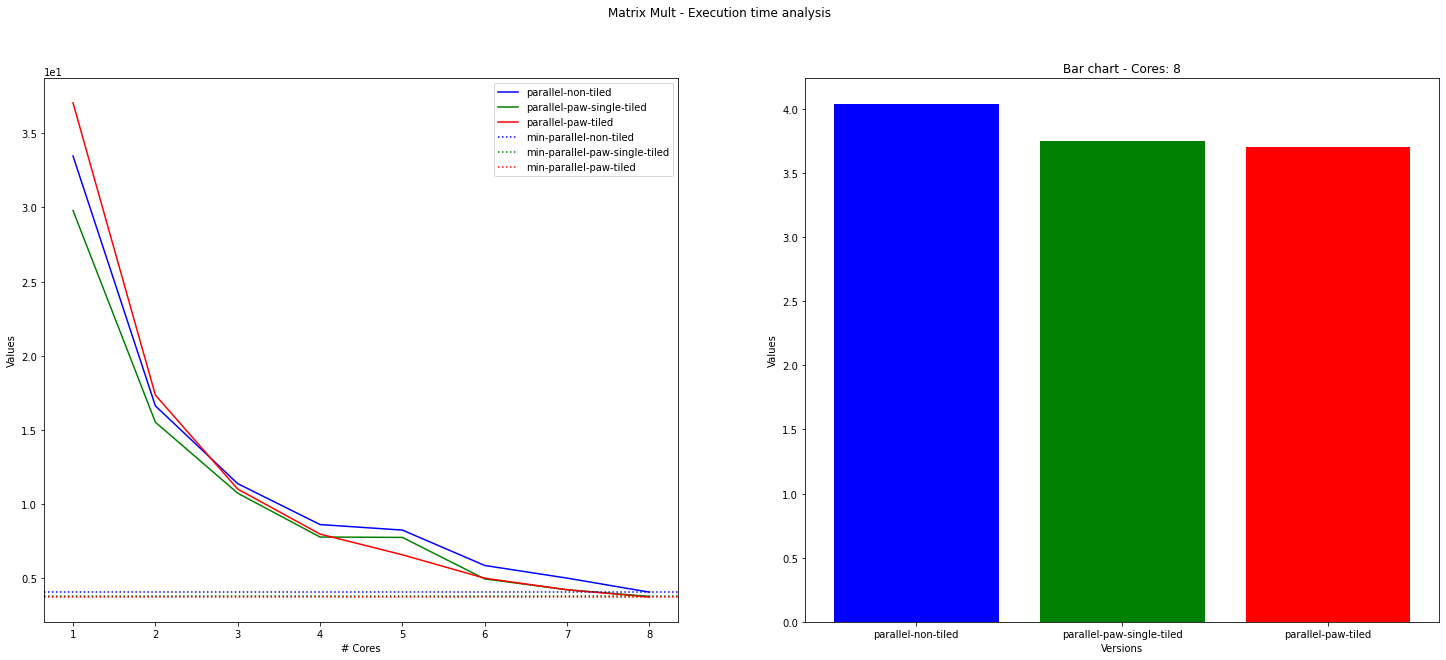

In [169]:
plot_experiments('Matrix Mult - Execution time',group_mean(df_mm_ex))

#### Observations
Unexpectedly, the **paw tiled** *(multi tiling)* version got the best performance and the the **single tiled** version got the worst performance. Due to these observations, one can suppose the following:
- paw single tiled version is not splitting the data in the best possible way, so the cache misses get increased and then the performance get decreased.
- In contrast, paw tiled version (multi-tiled version) is splitting the data in a better way and performance and cache hits get increased.


## Analysis

### Matrices



### Cache misses

Now, we are going to analyze the cache misses for the **matrix multiplication** algorithm.

KeyError: 'parallel-non-tiled'

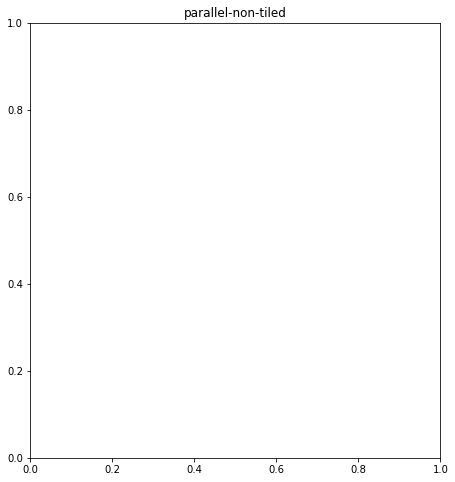

In [170]:
df_mm_cache = filter_by_experiment('matrix-mult','cache-misses')
exp = get_experimental_values(df_mm_cache)
plot_exp = get_plottable_experiment(exp)
plot_scatter(plot_exp, tick_format_style='sci')

In [171]:
df_std_mm_cache = group_by(df_mm_cache)
df_std_mm_cache = df_std_mm_cache.std()
df_std_mm_cache

,algorithm,version,cores,experiment,N,M,tileSize,value


KeyError: 'parallel-non-tiled'

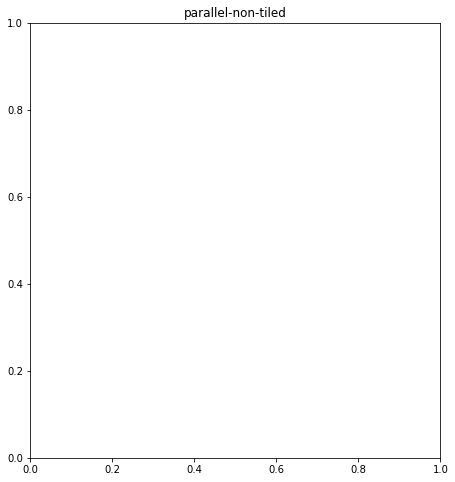

In [172]:
exp = get_experimental_values(df_std_mm_cache)
plot_exp = get_plottable_experiment(exp)
plot_scatter(plot_exp, tick_format_style='sci')

In [173]:
group_by(df_mm_cache).min()


,algorithm,version,cores,experiment,N,M,tileSize,value


IndexError: list index out of range

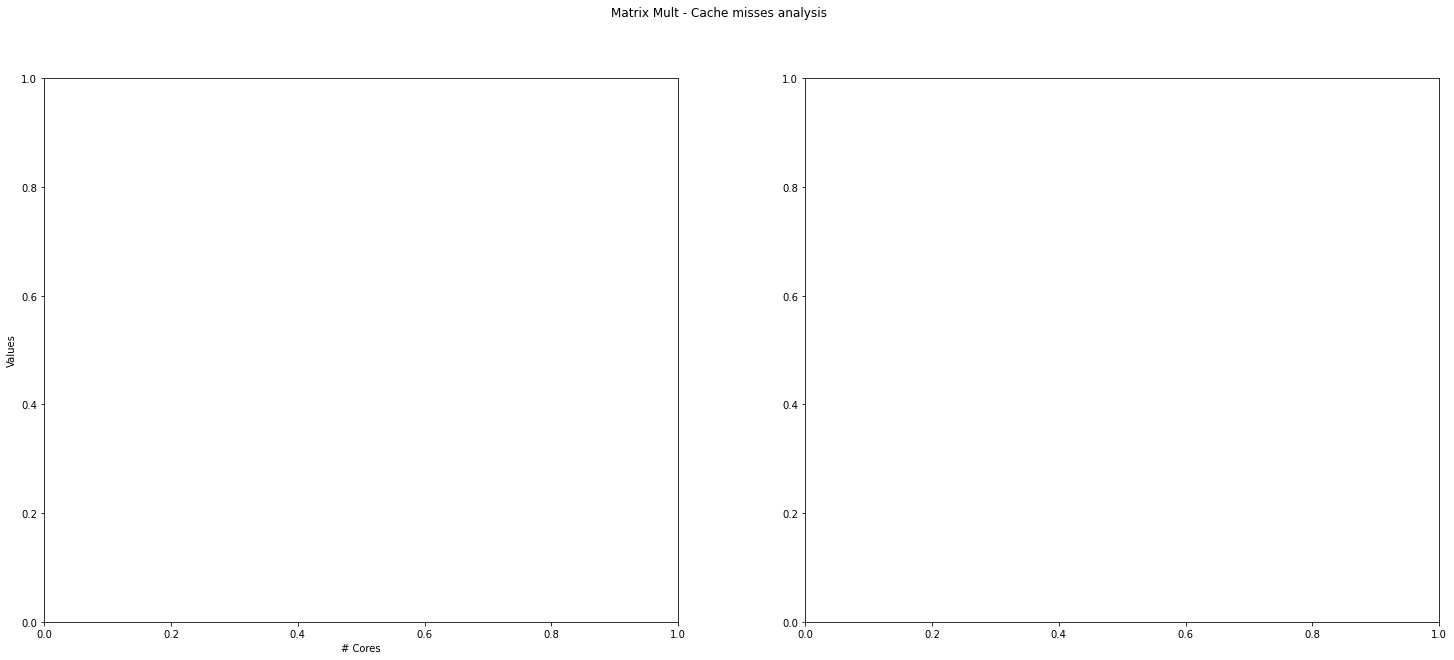

In [174]:
plot_experiments('Matrix Mult - Cache misses',group_by(df_mm_cache).min())
## Use min to see 

In [175]:
#Sanity check : What is expected?

### Total of instructions executed

In [176]:
df_mm_ti = filter_by_experiment('matrix-mult','total-instructions')
df_mm_ti

,algorithm,version,cores,experiment,N,M,tileSize,value


KeyError: 'parallel-non-tiled'

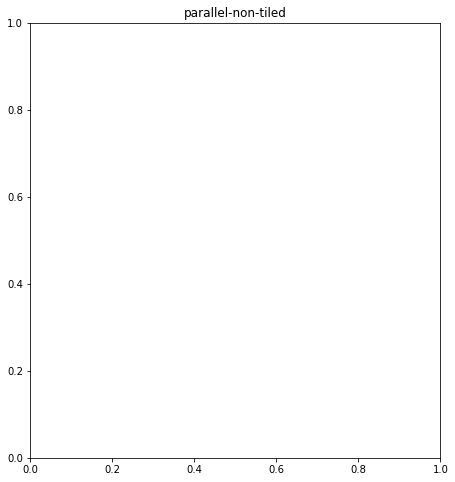

In [177]:
exp = get_experimental_values(df_mm_ti)
plot_exp = get_plottable_experiment(exp)
plot_scatter(plot_exp, tick_format_style='sci')

IndexError: list index out of range

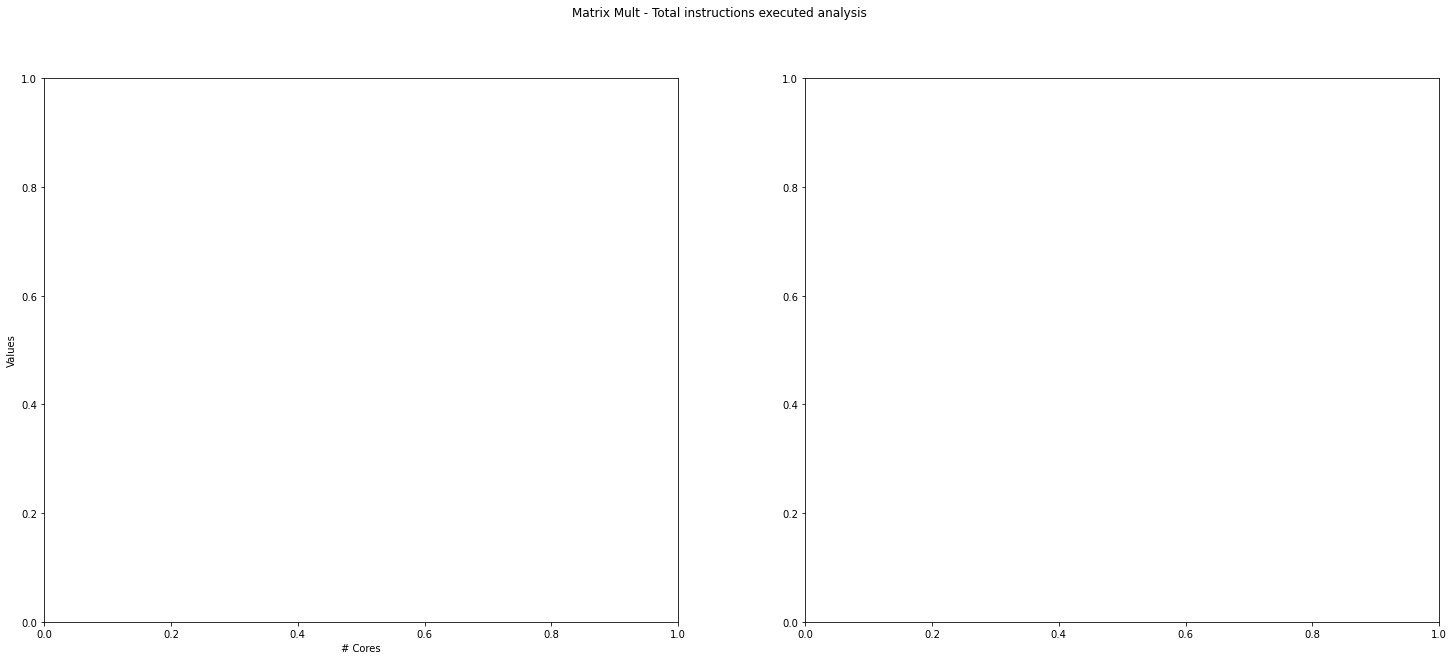

In [178]:
plot_experiments('Matrix Mult - Total instructions executed',group_by(df_mm_ti).min())

# Matrix-vector multiplication

## Matrix and vector size
For matrix multiplication we require 1 square matrix and 2 vectors. Looking for filling up the cache twice we will need to split double of the total amount of values in cache through the 3 matrices.
- Matrices will be **square**
- Data type: **float**

Matrix-vector multiplication defined as:

A*b = c

In [179]:
N = 4000 #use 2500 for darwin
M = (double_cache_values - N) / ( N + 1)
print(f"float type size: {round(type_size_in_bytes)}")
print(f"Total floating numbers to fill up cache: {round(total_values_in_cache)}")
print(f"Total floating numbers to double cache: {round(double_cache_values)}")
print(f"Matrix A: {round(N)}, {round(M)}")
print(f"vector b: {round(M)}")
print(f"vector c: {round(N)}")

print(f"total floating numbers: {round(M * N + N + M)}")

n=N
m=M

print(f"is cache smaller: {cache_size_in_bytes < (((4*m)+(4*n))+((4*m)*n))}")
print(f"is worth to parallelize: {m*n>100000}")

float type size: 4
Total floating numbers to fill up cache: 11796480
Total floating numbers to double cache: 23592960
Matrix A: 4000, 5896
vector b: 5896
vector c: 4000
total floating numbers: 23592960
is cache smaller: True
is worth to parallelize: True


## Analysis

### Cache misses

In [180]:
df_vm_cache = filter_by_experiment('vector-mult','cache-misses')
df_vm_cache

,algorithm,version,cores,experiment,N,M,tileSize,value


KeyError: 'parallel-non-tiled'

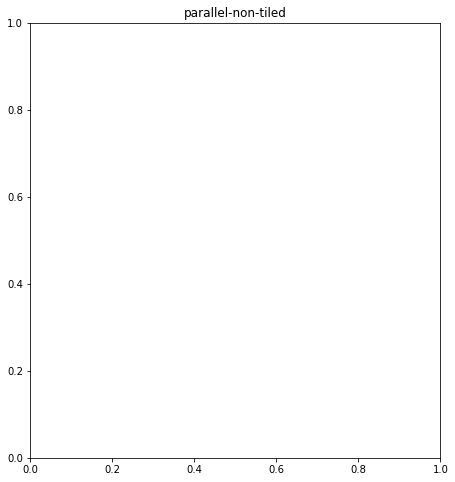

In [181]:
exp = get_experimental_values(df_vm_cache)
plot_exp = get_plottable_experiment(exp)
plot_scatter(plot_exp, tick_format_style='sci')

IndexError: list index out of range

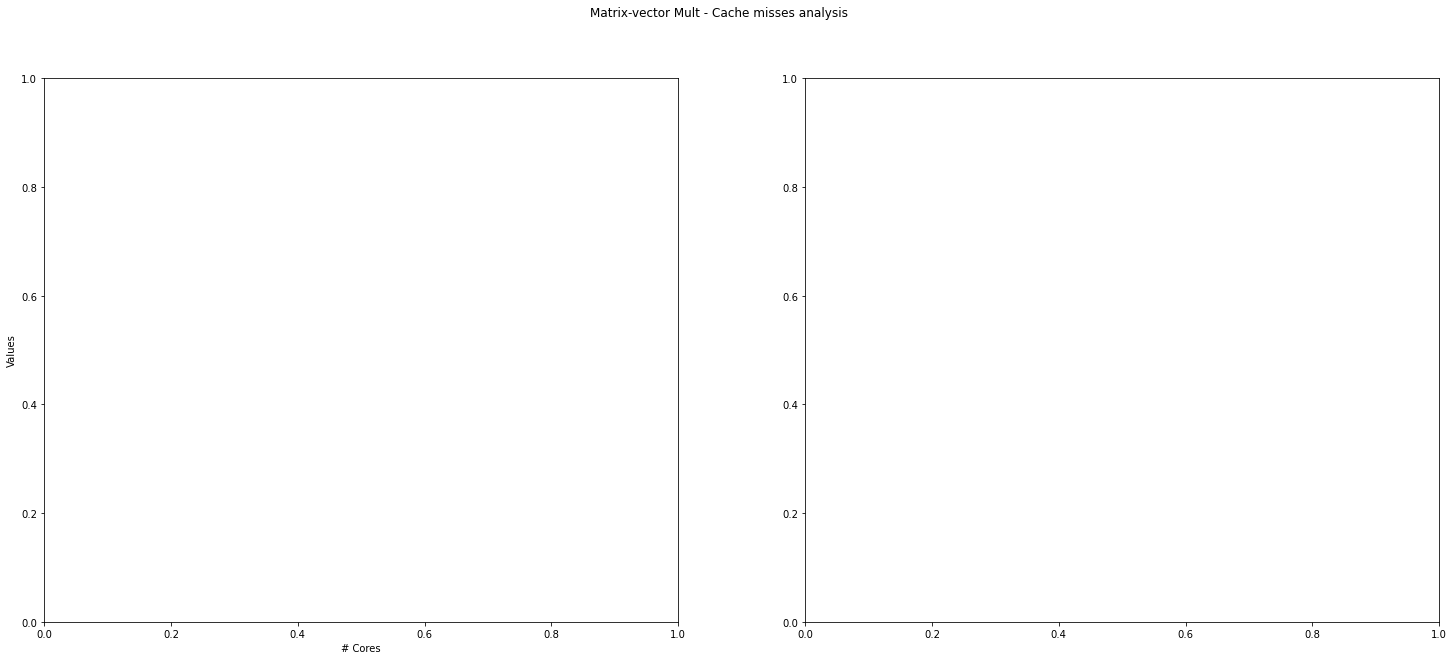

In [182]:
plot_experiments('Matrix-vector Mult - Cache misses',group_mean(df_vm_cache))

### Total of instructions executed

In [183]:
df_vm_ti = filter_by_experiment('vector-mult','total-instructions')
df_vm_ti

,algorithm,version,cores,experiment,N,M,tileSize,value


KeyError: 'parallel-non-tiled'

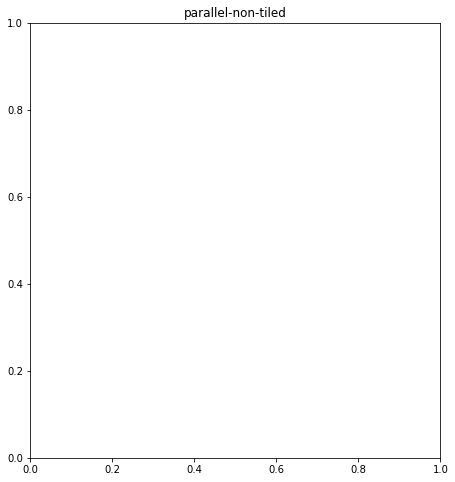

In [184]:
exp = get_experimental_values(df_vm_ti)
plot_exp = get_plottable_experiment(exp)
plot_scatter(plot_exp, tick_format_style='sci')

IndexError: list index out of range

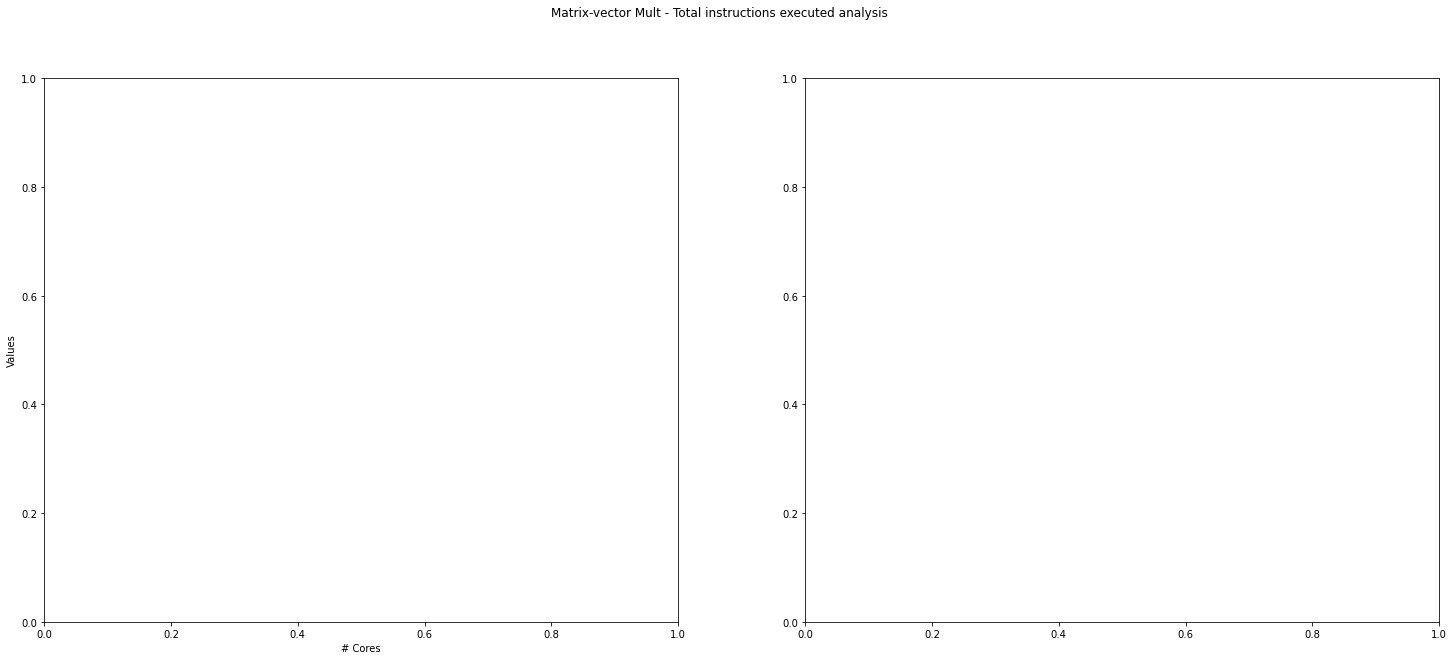

In [185]:
plot_experiments('Matrix-vector Mult - Total instructions executed',group_mean(df_vm_ti))

### Execution time

In [186]:
df_vm_ex = filter_by_experiment('vector-mult','speed-up')
df_vm_ex

,algorithm,version,cores,experiment,N,M,tileSize,value
4,vector-mult,parallel-non-tiled,1,speed-up,2500,3353,0,0.033925
9,vector-mult,parallel-non-tiled,1,speed-up,2500,3353,0,0.033766
10,vector-mult,parallel-non-tiled,1,speed-up,2500,3353,0,0.033766
12,vector-mult,parallel-non-tiled,1,speed-up,2500,3353,0,0.033798
14,vector-mult,parallel-non-tiled,1,speed-up,2500,3353,0,0.033750
...,...,...,...,...,...,...,...,...
344,vector-mult,parallel-non-tiled,8,speed-up,2500,3353,0,0.018509
349,vector-mult,parallel-paw-tiled,8,speed-up,2500,3353,214,0.026214
350,vector-mult,parallel-paw-single-tiled,8,speed-up,2500,3353,214,0.050795
355,vector-mult,parallel-paw-tiled,8,speed-up,2500,3353,214,0.031871


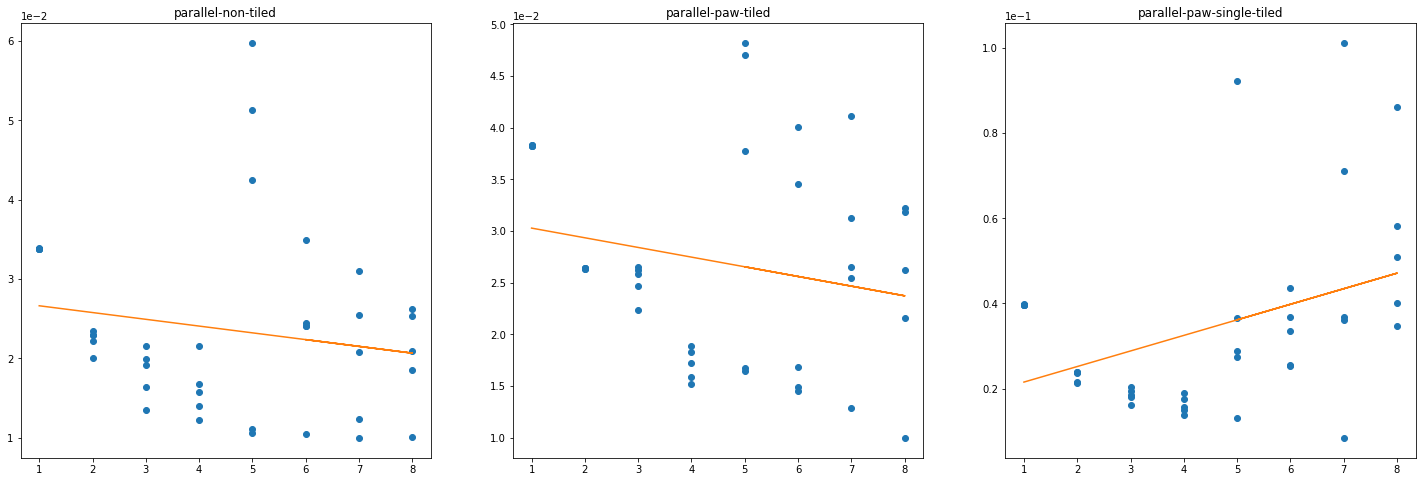

In [187]:
exp = get_experimental_values(df_vm_ex)
plot_exp = get_plottable_experiment(exp)
plot_scatter(plot_exp, tick_format_style='sci')

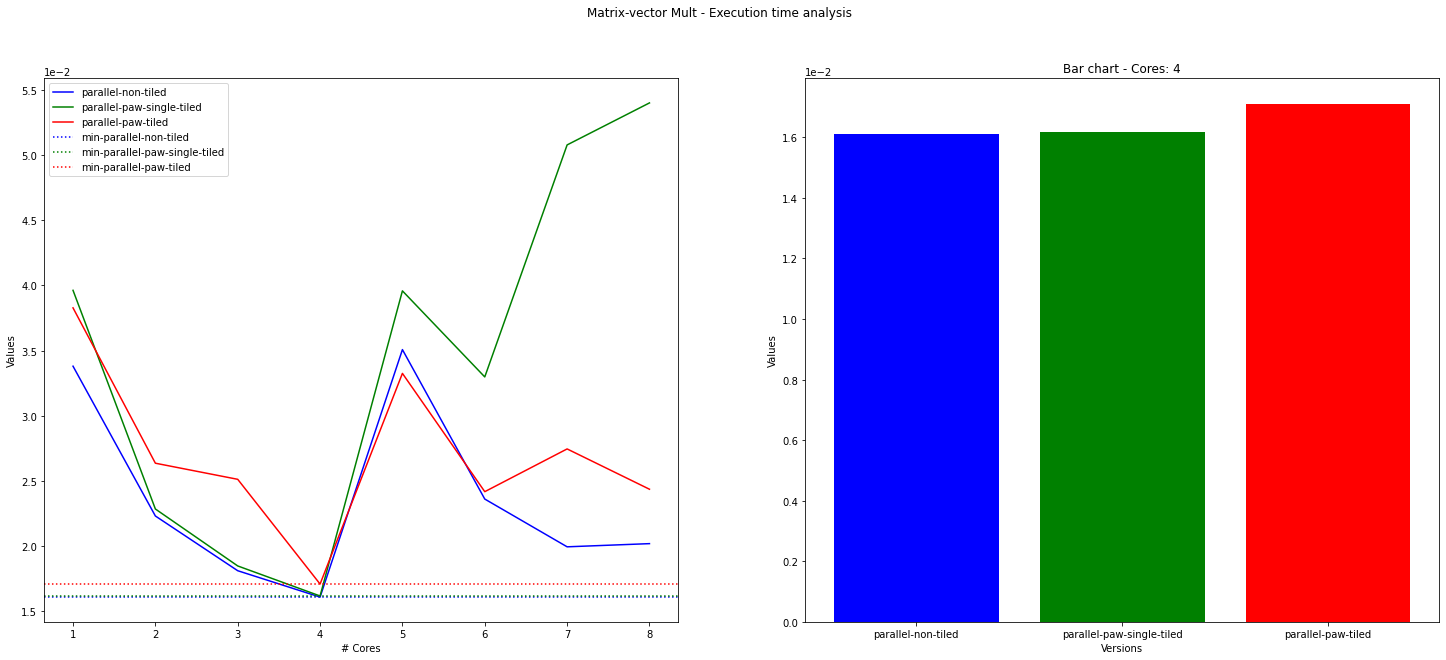

In [188]:
plot_experiments('Matrix-vector Mult - Execution time',group_mean(df_vm_ex))

# Jacobi

## Matrix size
For the jacobi algorithm we read from a single matrix. Looking for filling up the cache twice we will need to split double of the total amount of values in cache through the 1 matrix.
- Matrices will be **square**
- Data type: **float**

In [189]:
num_matrices = 1
total_values_per_matrix=double_cache_values/num_matrices
N_matrix = math.ceil(math.sqrt(total_values_per_matrix))
print(f"float type size: {round(type_size_in_bytes)}")
print(f"Total floating numbers to fill up cache: {round(total_values_in_cache)}")
print(f"Total floating numbers to double cache: {round(double_cache_values)}")
print(f"total floating numbers per matrix (1 matrices): {round(N_matrix*N_matrix)}")
print(f"rows and cols per matrix: {round(N_matrix)}")

print(N_matrix * N_matrix * N_matrix)

n=N_matrix
print(f"is cache smaller: {cache_size_in_bytes < ((8*n)*n)}")
print(f"is worth to parallelize: {1+(-2*n)+(n*n)>100000}")

float type size: 4
Total floating numbers to fill up cache: 11796480
Total floating numbers to double cache: 23592960
total floating numbers per matrix (1 matrices): 23600164
rows and cols per matrix: 4858
114649596712
is cache smaller: True
is worth to parallelize: True


## Analysis

### Cache misses

In [190]:
df_jb_cache = filter_by_experiment('jacobi','cache-misses')
df_jb_cache


,algorithm,version,cores,experiment,N,M,tileSize,value


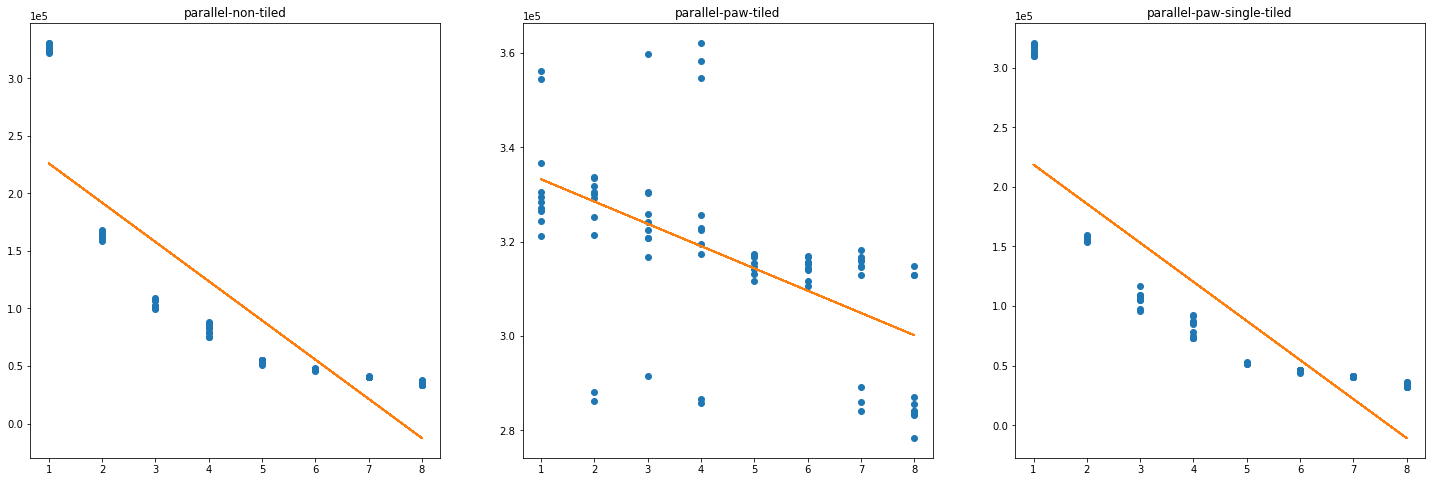

In [50]:
exp = get_experimental_values(df_jb_cache)
plot_exp = get_plottable_experiment(exp)
plot_scatter(plot_exp, tick_format_style='sci')

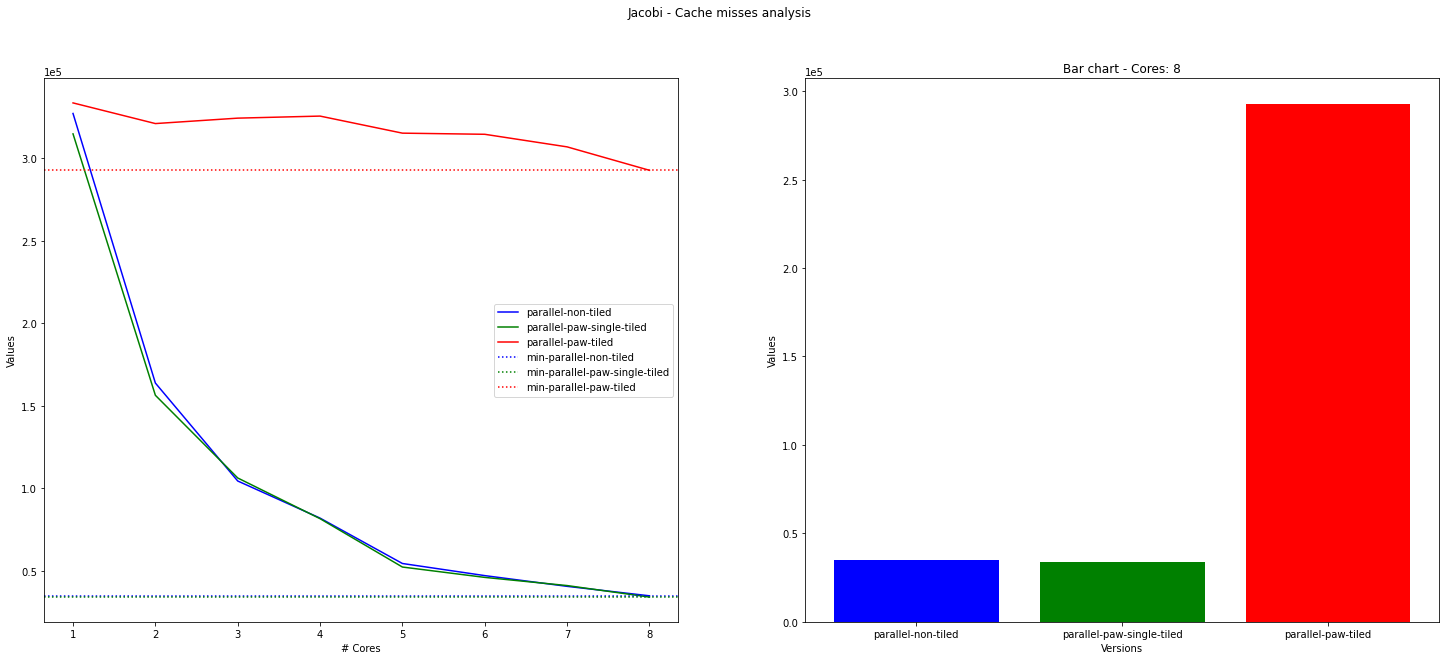

In [51]:
plot_experiments('Jacobi - Cache misses',group_mean(df_jb_cache))

### Total of instructions executed

In [52]:
df_jb_ti = filter_by_experiment('jacobi','total-instructions')
df_jb_ti

,algorithm,version,cores,experiment,N,M,value
78,jacobi,parallel-non-tiled,1,total-instructions,1200,1200,122005548.0
79,jacobi,parallel-paw-tiled,1,total-instructions,1200,1200,130636001.0
80,jacobi,parallel-paw-single-tiled,1,total-instructions,1200,1200,113971637.0
87,jacobi,parallel-non-tiled,2,total-instructions,1200,1200,61104348.0
88,jacobi,parallel-paw-tiled,2,total-instructions,1200,1200,130642842.0
...,...,...,...,...,...,...,...
1429,jacobi,parallel-paw-tiled,7,total-instructions,1200,1200,130647384.0
1430,jacobi,parallel-paw-single-tiled,7,total-instructions,1200,1200,17125867.0
1437,jacobi,parallel-non-tiled,8,total-instructions,1200,1200,15292683.0
1438,jacobi,parallel-paw-tiled,8,total-instructions,1200,1200,130648780.0


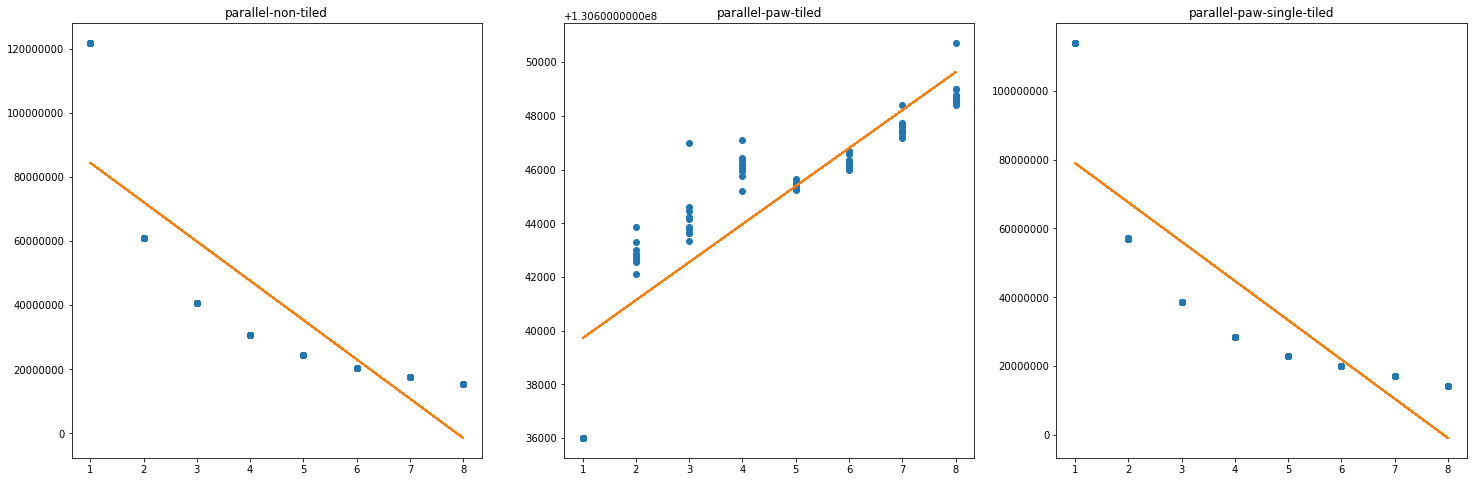

In [53]:
exp = get_experimental_values(df_jb_ti)
plot_exp = get_plottable_experiment(exp)
plot_scatter(plot_exp, tick_format_style='plain')

In [54]:
df_jb_ti[(df_jb_ti.version=='parallel-paw-tiled' )& (df_jb_ti.cores==2)]

,algorithm,version,cores,experiment,N,M,value
88,jacobi,parallel-paw-tiled,2,total-instructions,1200,1200,130642842.0
232,jacobi,parallel-paw-tiled,2,total-instructions,1200,1200,130642106.0
376,jacobi,parallel-paw-tiled,2,total-instructions,1200,1200,130643849.0
520,jacobi,parallel-paw-tiled,2,total-instructions,1200,1200,130642835.0
664,jacobi,parallel-paw-tiled,2,total-instructions,1200,1200,130642651.0
808,jacobi,parallel-paw-tiled,2,total-instructions,1200,1200,130643023.0
952,jacobi,parallel-paw-tiled,2,total-instructions,1200,1200,130642681.0
1096,jacobi,parallel-paw-tiled,2,total-instructions,1200,1200,130642778.0
1240,jacobi,parallel-paw-tiled,2,total-instructions,1200,1200,130643303.0
1384,jacobi,parallel-paw-tiled,2,total-instructions,1200,1200,130642554.0


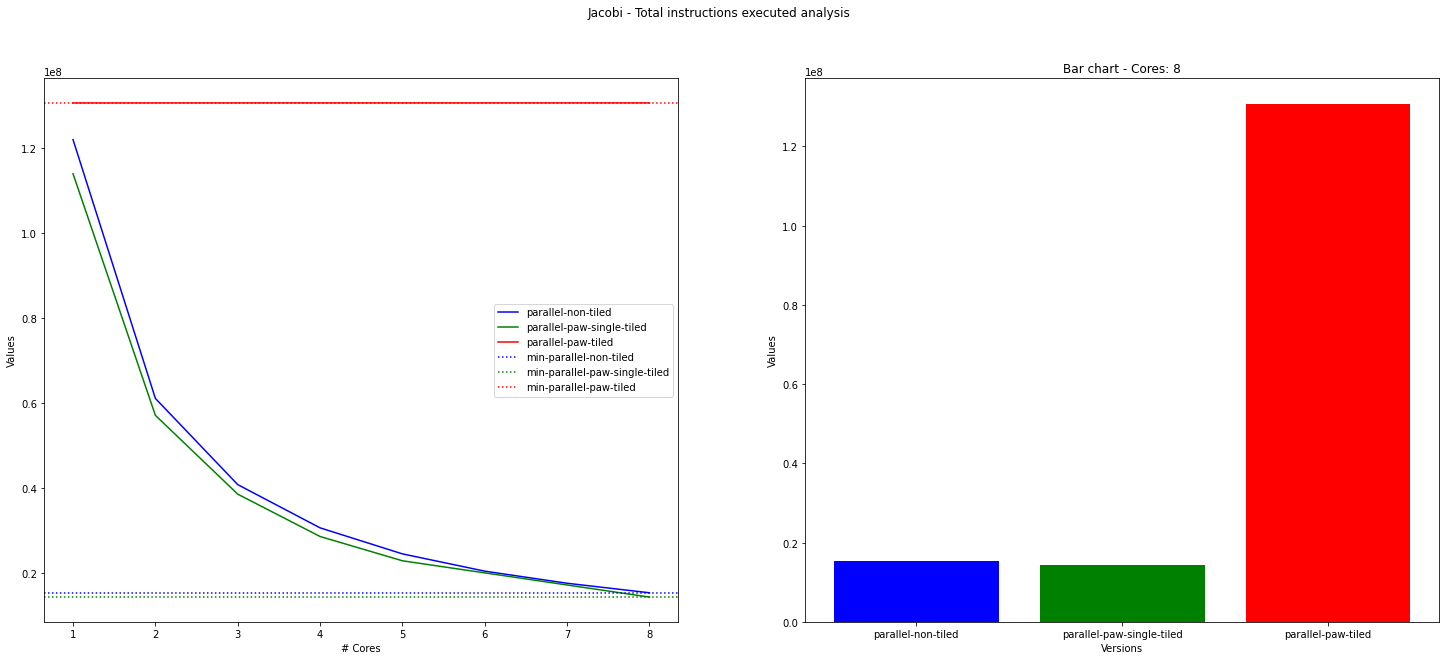

In [55]:
plot_experiments('Jacobi - Total instructions executed',group_mean(df_jb_ti))

### Execution time

In [191]:
df_jb_ex = filter_by_experiment('jacobi','speed-up')
df_jb_ex

,algorithm,version,cores,experiment,N,M,tileSize,value
19,jacobi,parallel-non-tiled,1,speed-up,2897,2897,0,0.112708
20,jacobi,parallel-paw-tiled,1,speed-up,2897,2897,1713,0.118676
23,jacobi,parallel-paw-single-tiled,1,speed-up,2897,2897,1713,0.135629
24,jacobi,parallel-paw-tiled,1,speed-up,2897,2897,1713,0.124809
25,jacobi,parallel-non-tiled,1,speed-up,2897,2897,0,0.130045
...,...,...,...,...,...,...,...,...
352,jacobi,parallel-paw-tiled,8,speed-up,2897,2897,214,0.049454
353,jacobi,parallel-paw-single-tiled,8,speed-up,2897,2897,214,0.056817
357,jacobi,parallel-non-tiled,8,speed-up,2897,2897,0,0.048033
358,jacobi,parallel-paw-tiled,8,speed-up,2897,2897,214,0.039143


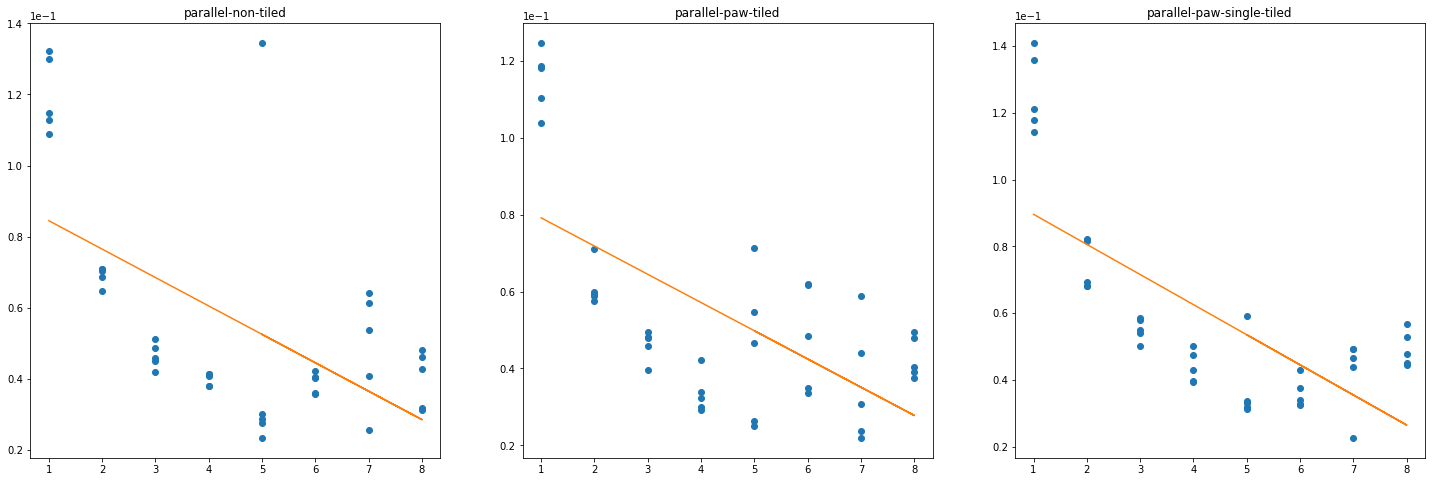

In [192]:
exp = get_experimental_values(df_jb_ex)
plot_exp = get_plottable_experiment(exp)
plot_scatter(plot_exp, tick_format_style='sci')

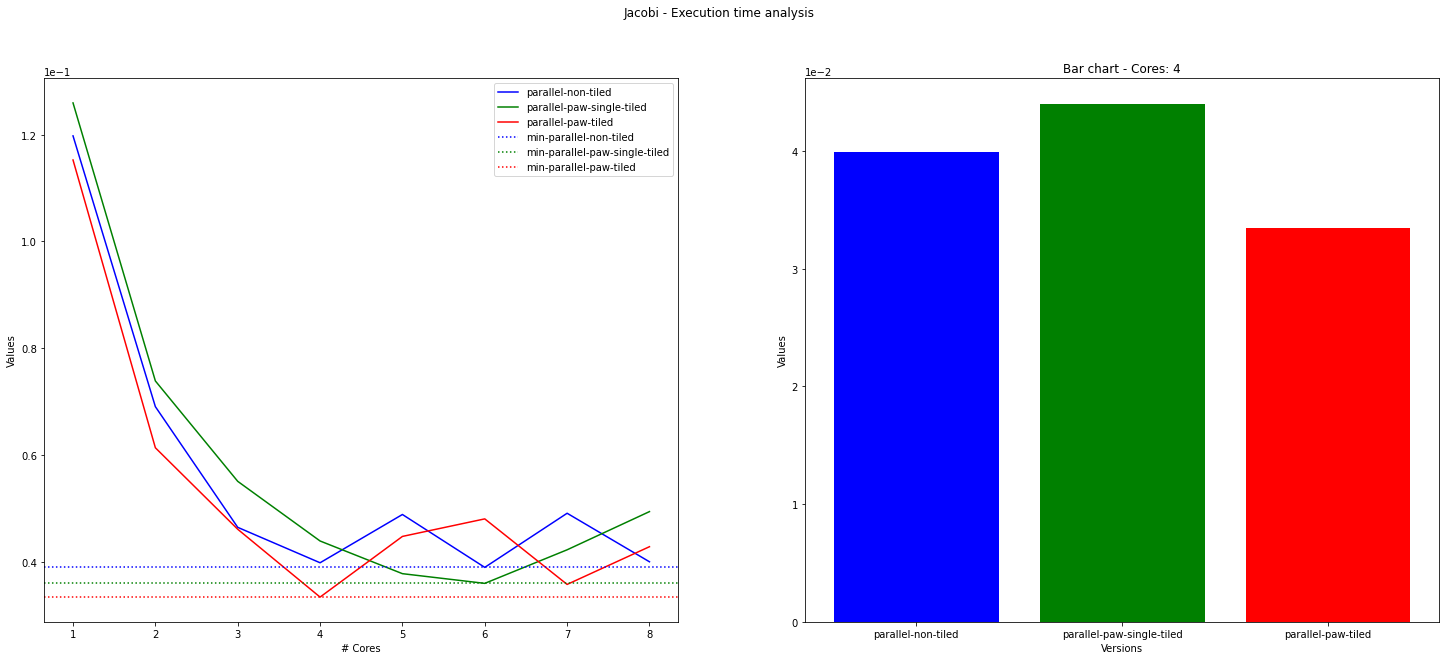

In [193]:
plot_experiments('Jacobi - Execution time',group_mean(df_jb_ex))

# Conclusions

- It looks like the effectivity is context-based.  For example, we could see some improvement over the cache hits and performance in the **matrix** and **vector-matrix** multiplication algorithms but it not the same case for the **jacobi** algorithm.